In [13]:
# Jupyter Notebook: Visualize simulated single-cell data and network

outfile='Network8'
# outfile='Network4'

import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import networkx as nx
import umap

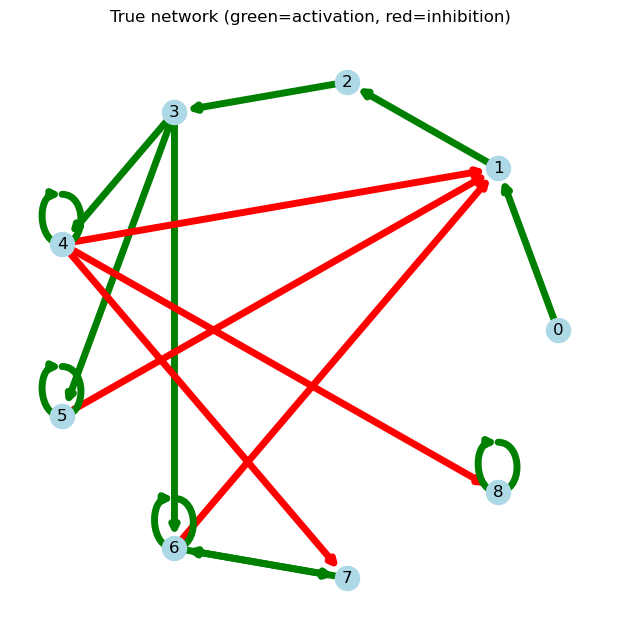

In [14]:
path_network = f'{outfile}/true/inter_signed.npy'

# ---------------------------------------------------------------------
# Visualize true network
# ---------------------------------------------------------------------
inter = np.load(path_network)
G = inter.shape[0]

# Create a directed graph
G_true = nx.DiGraph()
G_true.add_nodes_from(range(G))

# Add edges with sign
for i in range(G):
    for j in range(G):
        if inter[i,j] != 0:
            G_true.add_edge(i, j, weight=inter[i,j]*.5)

# Define edge colors: green for positive, red for negative
edge_colors = ['green' if G_true[u][v]['weight'] > 0 else 'red' for u,v in G_true.edges()]
edge_widths = [abs(G_true[u][v]['weight']) for u,v in G_true.edges()]

# Draw network
plt.figure(figsize=(6,6))
pos = nx.circular_layout(G_true)
nx.draw(G_true, pos, with_labels=True, node_color='lightblue',
        edge_color=edge_colors, width=edge_widths, arrowsize=10)
plt.title("True network (green=activation, red=inhibition)")
plt.show()

RNA shape: (1000, 9)
Protein shape: (1000, 9)
Time points: [  0  11  22  33  44  55  66  77  88 100]


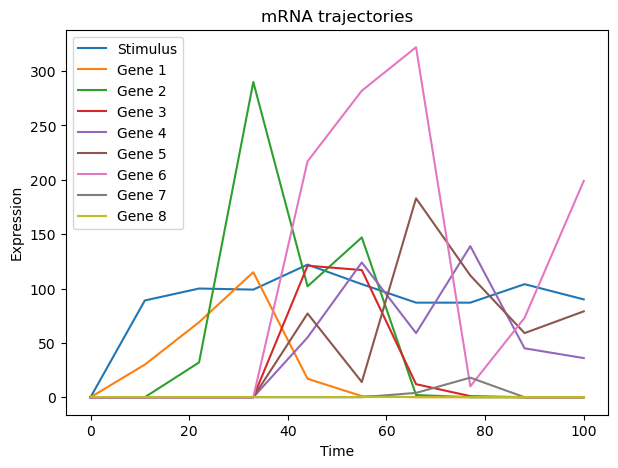

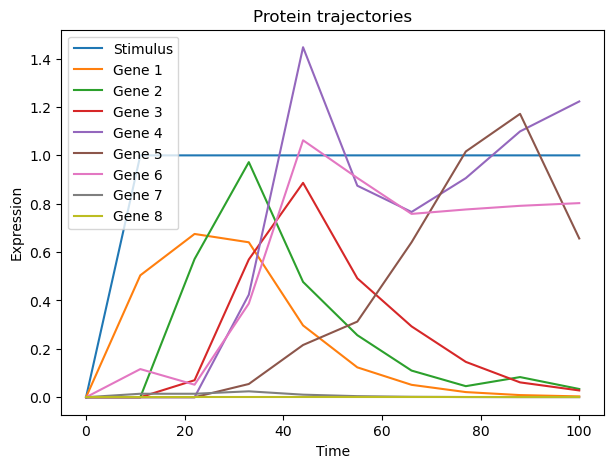

In [15]:
run = 1  # which simulation run to visualize
path_rna = f"{outfile}/data_rna/data_traj_{run}.h5ad"
path_prot = f"{outfile}/data_prot/data_traj_{run}.h5ad"

# ---------------------------------------------------------------------
# Load AnnData objects
# ---------------------------------------------------------------------
adata_rna = ad.read_h5ad(path_rna)
adata_prot = ad.read_h5ad(path_prot)

print("RNA shape:", adata_rna.X.shape)
print("Protein shape:", adata_prot.X.shape)
print("Time points:", np.unique(adata_rna.obs['time']))

# ---------------------------------------------------------------------
# Plot one trajectory per gene
# ---------------------------------------------------------------------
def plot_trajectories(adata, title):
    time_points = np.unique(adata.obs['time'])
    G = adata.X.shape[1]
    n = np.random.choice(np.sum(adata.obs['time']==0))
    
    plt.figure(figsize=(7,5))
    for g in range(G):
        traj_g = [adata.X[adata.obs['time']==t, g][n] for t in time_points]
        plt.plot(time_points, traj_g, label=f"Gene {g}" if g > 0 else "Stimulus")
    plt.xlabel("Time")
    plt.ylabel("Expression")
    plt.title(title)
    plt.legend()
    plt.show()

plot_trajectories(adata_rna, "mRNA trajectories")
plot_trajectories(adata_prot, "Protein trajectories")


/opt/homebrew/Caskroom/miniconda/base/envs/cardamom/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cardamom/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


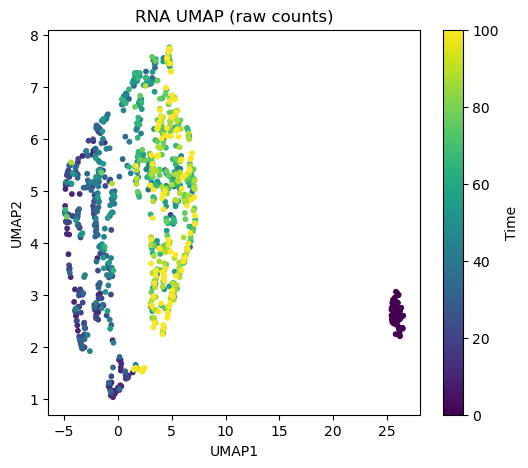

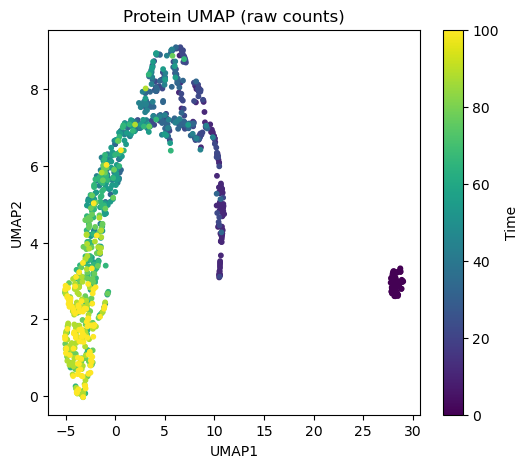

In [16]:
# ---------------------------------------------------------------------
# Compute UMAP embeddings (raw data)
# ---------------------------------------------------------------------
def compute_umap(X, n_neighbors=15, min_dist=0.1, metric='euclidean', seed=0):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=seed)
    embedding = reducer.fit_transform(X)
    return embedding

embedding_rna = compute_umap(adata_rna.X)
embedding_prot = compute_umap(adata_prot.X)

# ---------------------------------------------------------------------
# Plot embeddings
# ---------------------------------------------------------------------
def plot_umap(embedding, time, title):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(embedding[:,0], embedding[:,1], c=time, cmap='viridis', s=10)
    plt.colorbar(sc, label='Time')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(title)
    plt.show()

plot_umap(embedding_rna, adata_rna.obs['time'].values, "RNA UMAP (raw counts)")
plot_umap(embedding_prot, adata_prot.obs['time'].values, "Protein UMAP (raw counts)")

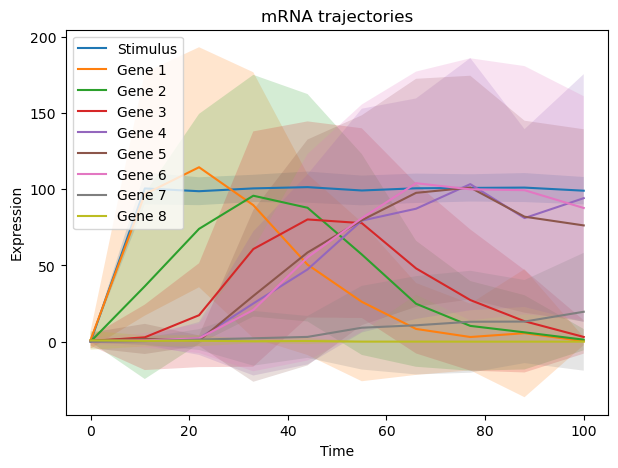

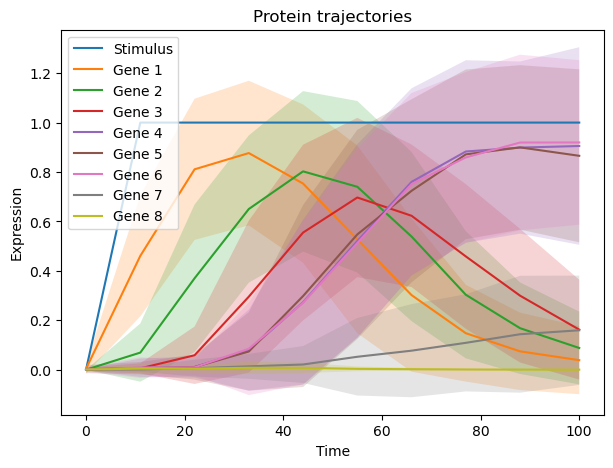

RNA mean expression per gene:
[90.15  39.558 39.355 33.094 52.005 52.817 55.125  7.287  0.261]

Protein mean expression per gene:
[0.9        0.39949322 0.37300289 0.31551631 0.43392363 0.42987226
 0.43364142 0.05835566 0.00311934]


In [17]:
run = 3  # which simulation run to visualize
path_rna = f'{outfile}/data_rna/data_distributions_{run}.h5ad'
path_prot = f'{outfile}/data_rna/data_distributions_{run}.h5ad'

# ---------------------------------------------------------------------
# Plot trajectories of mean ± std per gene
# ---------------------------------------------------------------------
def plot_trajectories(adata, title):
    time_points = np.unique(adata.obs['time'])
    G = adata.X.shape[1]
    
    plt.figure(figsize=(7,5))
    for g in range(G):
        mean_g = [adata.X[adata.obs['time']==t, g].mean() for t in time_points]
        std_g  = [adata.X[adata.obs['time']==t, g].std() for t in time_points]
        plt.plot(time_points, mean_g, label=f"Gene {g}" if g > 0 else "Stimulus")
        plt.fill_between(time_points,
                         np.array(mean_g)-np.array(std_g),
                         np.array(mean_g)+np.array(std_g),
                         alpha=0.2)
    plt.xlabel("Time")
    plt.ylabel("Expression")
    plt.title(title)
    plt.legend()
    plt.show()

plot_trajectories(adata_rna, "mRNA trajectories")
plot_trajectories(adata_prot, "Protein trajectories")

# ---------------------------------------------------------------------
# Quick summary statistics
# ---------------------------------------------------------------------
print("RNA mean expression per gene:")
print(adata_rna.X.mean(axis=0))
print("\nProtein mean expression per gene:")
print(adata_prot.X.mean(axis=0))

/opt/homebrew/Caskroom/miniconda/base/envs/cardamom/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/cardamom/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


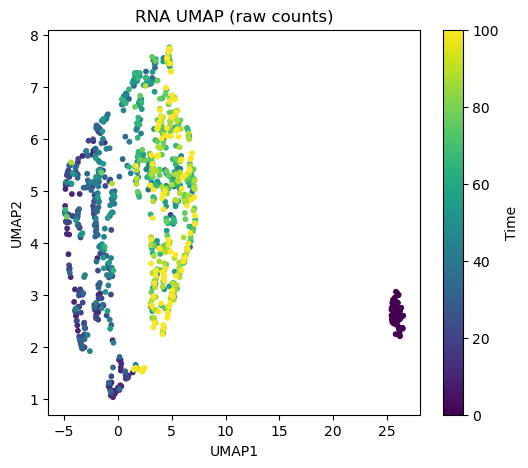

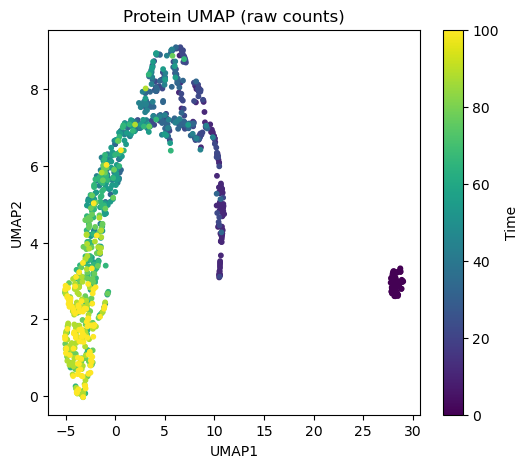

In [18]:
# ---------------------------------------------------------------------
# Compute UMAP embeddings (raw data)
# ---------------------------------------------------------------------
def compute_umap(X, n_neighbors=15, min_dist=0.1, metric='euclidean', seed=0):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=seed)
    embedding = reducer.fit_transform(X)
    return embedding

embedding_rna = compute_umap(adata_rna.X)
embedding_prot = compute_umap(adata_prot.X)

# ---------------------------------------------------------------------
# Plot embeddings
# ---------------------------------------------------------------------
def plot_umap(embedding, time, title):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(embedding[:,0], embedding[:,1], c=time, cmap='viridis', s=10)
    plt.colorbar(sc, label='Time')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(title)
    plt.show()

plot_umap(embedding_rna, adata_rna.obs['time'].values, "RNA UMAP (raw counts)")
plot_umap(embedding_prot, adata_prot.obs['time'].values, "Protein UMAP (raw counts)")